In [1]:
import tensorflow as tf
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

2024-05-16 00:36:51.222608: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-16 00:36:51.260183: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-16 00:36:51.515177: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-16 00:36:51.516548: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-16 00:36:52.316863: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
with open('X.pkl', 'rb') as f:
    loaded_array = pickle.load(f)

X = loaded_array

with open('y.pkl', 'rb') as f:
    loaded_array = pickle.load(f)

y = loaded_array

2024-05-16 00:36:54.410638: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-16 00:36:54.411558: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
X[0].shape

TensorShape([124, 1024])

In [4]:
print("len(X):", len(X))
print("len(y):", len(y))

len(X): 1475
len(y): 1475


In [5]:
num_classes = 5
y = tf.keras.utils.to_categorical(y, num_classes)

In [6]:
y

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
print("len(X_train):", len(X_train))
print("len(X_test):", len(X_test))
print("len(y_train):", len(y_train))
print("len(y_test):", len(y_test))

len(X_train): 1180
len(X_test): 295
len(y_train): 1180
len(y_test): 295


In [9]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [10]:
import tensorflow as tf
from tensorflow.keras import regularizers


model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(124, 1024), dtype=tf.float32, name='input_embedding'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
], name='yamnet_model')


# Compile the model
METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=METRICS)


model.summary()

Model: "yamnet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 126976)            0         
                                                                 
 dense (Dense)               (None, 1024)              130024448 
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                      

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

EPOCHS = 10
early_stopping = EarlyStopping(monitor='val_loss', patience=EPOCHS//3, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data = (X_test, y_test), batch_size=32,callbacks=[early_stopping])

Epoch 1/10
37/37 [==============================] - 63s 1s/step - loss: 6.2946 - accuracy: 0.3915 - precision: 0.4426 - recall: 0.2449 - val_loss: 9.0142 - val_accuracy: 0.4102 - val_precision: 0.4307 - val_recall: 0.3898
Epoch 2/10
37/37 [==============================] - 48s 1s/step - loss: 6.1887 - accuracy: 0.6136 - precision: 0.7057 - recall: 0.4754 - val_loss: 6.2048 - val_accuracy: 0.5390 - val_precision: 0.6017 - val_recall: 0.4915
Epoch 3/10
37/37 [==============================] - 55s 1s/step - loss: 5.0391 - accuracy: 0.7483 - precision: 0.8052 - recall: 0.6517 - val_loss: 4.9866 - val_accuracy: 0.6542 - val_precision: 0.7467 - val_recall: 0.5695
Epoch 4/10
37/37 [==============================] - 55s 1s/step - loss: 4.0821 - accuracy: 0.8517 - precision: 0.8940 - recall: 0.8144 - val_loss: 4.1742 - val_accuracy: 0.7797 - val_precision: 0.8263 - val_recall: 0.7254
Epoch 5/10
37/37 [==============================] - 50s 1s/step - loss: 3.6548 - accuracy: 0.8847 - precision: 0

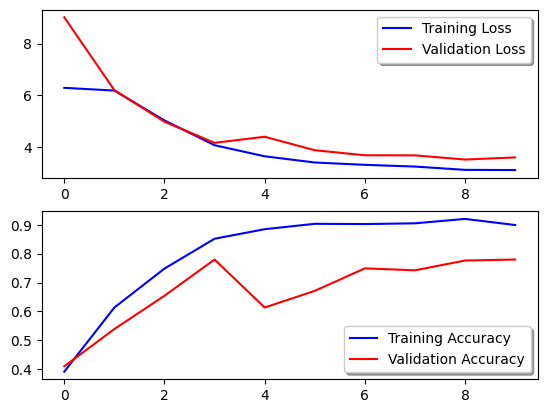

In [15]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training Loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation Loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training Accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [16]:
evaluation = model.evaluate(X_test, y_test)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

10/10 [==============================] - 1s 103ms/step - loss: 3.6115 - accuracy: 0.7797 - precision: 0.8088 - recall: 0.7458
Test Accuracy : 77.97%


10/10 [==============================] - 1s 71ms/step


<Axes: >

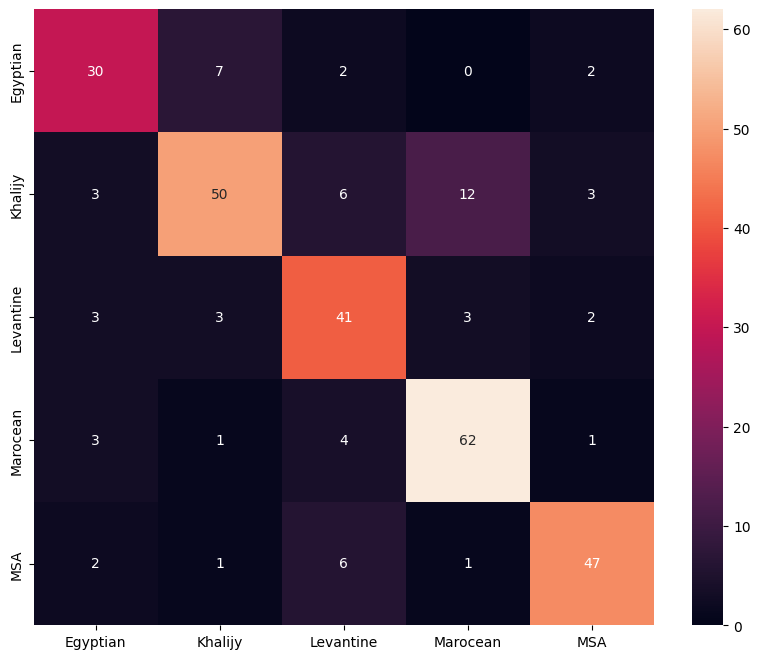

In [18]:
class_names = ["Egyptian", "Khalijy", "Levantine", "Marocean", "MSA"]

# Predict the values from the testing dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert testing observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1)
# compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='g',xticklabels=class_names, yticklabels=class_names)

In [19]:
from sklearn.metrics import classification_report
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.73      0.73      0.73        41
           1       0.81      0.68      0.74        74
           2       0.69      0.79      0.74        52
           3       0.79      0.87      0.83        71
           4       0.85      0.82      0.84        57

    accuracy                           0.78       295
   macro avg       0.78      0.78      0.78       295
weighted avg       0.78      0.78      0.78       295



In [20]:
model.save('yamnet_modelV2.h5')

/home/hassan/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


: 

In [ ]:
model = tf.keras.models.load_model('yamnet_model.h5')